## A/B Testing Notebook
Vikram Reddy

8/15/2017

Problem: Goal
A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy, and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientists to work on more high level topics.
In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

**Challenge Description**

Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!
You are asked to:

Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
Explain why that might be happening. Are the localized translations really worse?

If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [2. Transform Data](#Transform-Data)
### [3. Check if A/B Test is Valid](#Descriptive-Statistics)
### [4. Recreate A/B Test](#Baseline-Models)
### [5. Four Reasons why Result of A/B Test may not be Valid](#Error-Analysis)
### [6. Testing Reason One: Not Enough Data](#Change-the-Baseline)
### [7. Testing Reason Two: Treatment and Control not randomized](#Decision-Tree)

### Imported Modules
[Top](#Table-of-Contents)

In [4]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sbn

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Load Data
[Top](#Table-of-Contents)

In [5]:
user_table = pd.read_csv('../../data/Translation_Test/user_table.csv')
test_table = pd.read_csv('../../data/Translation_Test/test_table.csv')
user_orig = user_table.copy()
test_orig = test_table.copy()

### Transform Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

In [6]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


### Description of Test Table columns

Columns:
- user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
- date : when they came to the site for the first time since the test started
- source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
- device : device used by the user. It can be mobile or web
- browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 
- ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
- browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
- conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
- test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

### Description of User Table columns

Columns:
- user_id : the id of the user. It can be joined to user id in the other table sex : user sex: Male or Female
- age : user age (self-reported)
- country : user country based on ip address

Check for nulls other than the ones built in to the tables.

In [8]:
user_table.isnull().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

Ads channel is null when the user did not come to the page through an ad

In [9]:
test_table.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [10]:
len(test_table['ads_channel'])

453321

In [11]:
user_table.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [12]:
test_table.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


Let me join the two tables along the user_id.

To prepare for the join, I will check to see if there are differences in the primary key (user_id) of each table.

In [13]:
len(test_table.user_id) - len(user_table.user_id)

454

In [14]:
# pandasql
from pandasql import sqldf

run_query = lambda q: sqldf(q, globals())

So there are 454 more user_id entries in the test table than in the user table. However, there may be duplicate entries. I will now test for duplicates.

In [15]:
distinct = '''
    SELECT COUNT(DISTINCT user_id) as unique_user
    FROM user_table
'''
distinct_test = '''
    SELECT COUNT(DISTINCT user_id) as unique_user
    FROM test_table
'''

In [16]:
table = 'user_table'
unique_users = run_query(distinct)

In [17]:
user_table_is_unique = unique_users['unique_user'] ==\
    len(user_table['user_id'])
test_table_is_unique = run_query(distinct_test) ==\
    len(test_table['user_id'])

In [18]:
print(user_table_is_unique, test_table_is_unique)

0    True
Name: unique_user, dtype: bool    unique_user
0         True


Both tables have no duplicates in user_ids. So there are 454 more unique users in the test table than in the users table. I will perform a left join to keep these extra users' information.

In [19]:
test_left_user = '''
SELECT * FROM
    test_table AS tests
    LEFT JOIN user_table AS users
        ON tests.user_id = users.user_id
'''

In [20]:
test_left_user_df = run_query(test_left_user)

In [21]:
join_tables = '''
SELECT * FROM test_table tests
    LEFT JOIN
    user_table users
        ON users.user_id = tests.user_id
'''
user_and_test = run_query(join_tables)

In [22]:
inner_join = '''
SELECT * FROM user_table users
    INNER JOIN
    test_table test
    ON test.user_id = users.user_id;
'''
user_inner_test = run_query(inner_join)

In [23]:
user_and_test.shape[0] - user_inner_test.shape[0]

454

The intersection is 454 less than the LEFT JOIN, as expected.

#### Creating dummy variables

In [24]:
test_left_user_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,user_id,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,None,IE,1,0,315281.0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,497851.0,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,848402.0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,290051.0,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,548435.0,M,19.0,Mexico


## First, check if reason to do A/B Test is valid.

That is, check if Spain is better than the other countries before the introduction of the event (new translators).

#### Pandas version

In [28]:
test_left_user_df[test_left_user_df['test']==0].groupby('country').mean()['conversion']\
    .sort_values(ascending=False)

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

#### SQL version

In [29]:
is_Spain_better = '''
    SELECT country,
        AVG(conversion) AS avg_conversion_rate
        FROM test_left_user_df
        WHERE test = 0
        GROUP BY country
        ORDER BY 2 DESC;
'''

In [30]:
run_query(is_Spain_better)

,country,avg_conversion_rate
0,Spain,0.079719
1,None,0.077551
2,El Salvador,0.053554
3,Nicaragua,0.052647
4,Costa Rica,0.052256
5,Colombia,0.052089
6,Honduras,0.050906
7,Guatemala,0.050643
8,Venezuela,0.050344
9,Peru,0.049914


Indeed, Spain converts at about 8% while other countries convert at 5.3% or lower.

## Next, recreate the A/B Test and analyze the difference of means

Difference of means is (the avg measurement of the metric in test) - (avg measurement of the metric in control).

In [31]:
df = test_left_user_df.copy()

In [32]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,user_id,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,None,IE,1,0,315281.0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,497851.0,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,848402.0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,290051.0,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,548435.0,M,19.0,Mexico


#### Pandas version

Remove Spain. The test only involves the difference in means for the other countries. Spain's translators were not changed.

In [33]:
df_no_Spain = df[df['country'] != 'Spain']

Extract Test.

In [36]:
df_test = df_no_Spain[df_no_Spain['test'] == 1]

Extract Control.

In [38]:
df_control = df_no_Spain[df_no_Spain['test'] == 0]

Calculate difference in means.

In [43]:
diff_in_means = (df_test.groupby('country').mean()['conversion'] - \
    df_control.groupby('country').mean()['conversion']).sort_values(ascending=False)

In [44]:
diff_in_means

country
Chile          0.003188
Panama         0.002575
Costa Rica     0.002482
Mexico         0.001692
Nicaragua      0.001530
Uruguay        0.000859
Paraguay       0.000736
Peru           0.000690
Ecuador       -0.000165
Argentina     -0.001346
Venezuela     -0.001365
Bolivia       -0.001468
Colombia      -0.001519
Guatemala     -0.001996
Honduras      -0.003366
El Salvador   -0.005607
Name: conversion, dtype: float64

If I take the average difference in means for all countries:

In [65]:
diff_all_countries = df_test['conversion'].mean() - df_control['conversion'].mean()

In [66]:
diff_all_countries

-0.0048806288790724447

So there was a average of 0.5% drop in conversion when the local translators were introduced. That is, the test was negative--it did not increase the conversion rate.

Calculate statistical significance of this difference in means.

In [60]:
from scipy.stats import ttest_ind

In [61]:
ttest_ind(df_test['conversion'], df_control['conversion'])

Ttest_indResult(statistic=-7.3822521630539679, pvalue=1.559329277881674e-13)

The p-value is around 0, way less than 5%, so the test is significant! Apparently..

#### SQL version

Remove Spain.

In [45]:
no_Spain = '''
    SELECT * FROM df
    WHERE country != 'Spain'
'''

In [47]:
df_no_Spain = run_query(no_Spain)

Extract Test.

In [48]:
test_set = '''
    SELECT *
    FROM df_no_Spain
    WHERE test = 1
'''

In [49]:
df_test = run_query(test_set)

Extract Control.

In [50]:
control_set = '''
    SELECT * 
    FROM df_no_Spain
    WHERE test = 0;
'''

In [51]:
df_control = run_query(control_set)

Calculate diff in means.

In [57]:
calc_diff_means = '''
    SELECT t.country, t.avg_test - c.avg_control AS difference
    FROM 
    (
        SELECT country,
            AVG(conversion) AS avg_test
        FROM df_test
        GROUP BY country
    ) t JOIN
    (
        SELECT country,
            AVG(conversion) AS avg_control
        FROM df_control
        GROUP BY country
    ) c
        ON t.country = c.country
    ORDER BY difference DESC;
'''

In [58]:
diff_in_means = run_query(calc_diff_means)

In [64]:
diff_in_means

,country,difference
0,Chile,0.003188
1,Panama,0.002575
2,Costa Rica,0.002482
3,Mexico,0.001692
4,Nicaragua,0.001530
5,Uruguay,0.000859
6,Paraguay,0.000736
7,Peru,0.000690
8,Ecuador,-0.000165
9,Argentina,-0.001346


I skipped writing the SQL query for the overall avg difference. Above, I controlled for country.

In [32]:
from scipy.stats import ttest_ind

In [33]:
pvalue

1.15144687852198e-13

Get the difference in means

In [34]:
test.mean()*100, control.mean()*100

(4.342471398211897, 4.833042316066309)

The mean in the test set is 4.3% while the mean in the control is 4.8% conversions. So the number of conversions seems to have decreased by .5% when the company hired local translators.

This result can be incorrect for 4 reasons. First, the randomization into treatment and controls group might not have been completely random. As a result, there might be some bias introduced to either group. 

Second, we might not have collected enough data. To check how much data we collected when running these tests, let's analyze the number of conversions per day.

Third, the 'conversions' metric may not be the best measure of them buying the software. In this case, though, the metric 'conversions' is pretty reliant.

Fourth, there may be a confounding factor or an interaction effect that is preventing the wanted behavior from occurring.

### 1.) Not enough Data

In [84]:
# Not enough data
metrics_logged_per_day = df_no_Spain.groupby('date').sum().reset_index()

In [85]:
metrics_logged_per_day

,date,user_id,conversion,test,age
0,2015-11-30,3.138403e+10,2969,33844,1703095.0
1,2015-12-01,3.138309e+10,2741,33840,1703075.0
2,2015-12-02,3.115190e+10,2883,33517,1693378.0
3,2015-12-03,4.408466e+10,4086,47383,2389136.0
4,2015-12-04,6.249762e+10,5637,67190,3392010.0


The experiment was only run for 5 days. This is not enough time to gather statistically significant information.

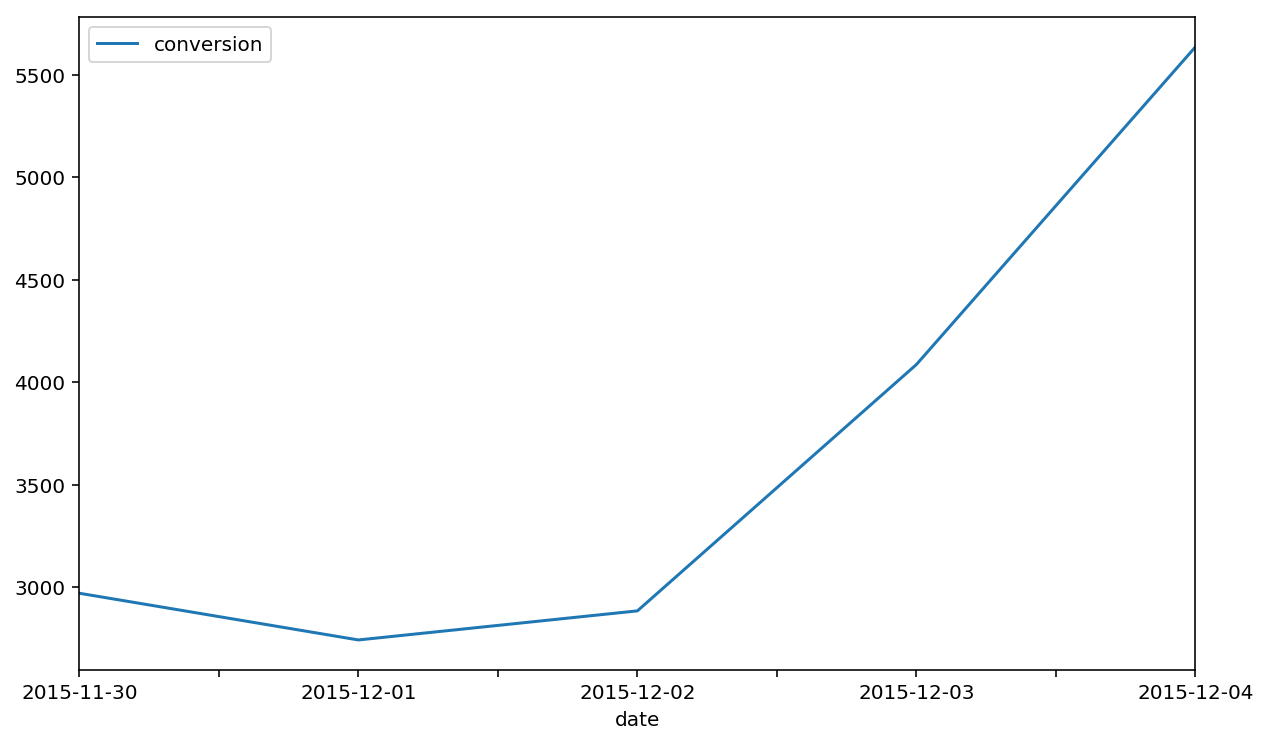

In [86]:
metrics_logged_per_day[['date', 'conversion']].plot(x='date', y='conversion', figsize=(10,6))

In [36]:
num_conversions_per_day = df_notSpain.groupby('date').sum()['conversion']

In [37]:
x, y = num_conversions_per_day.index, num_conversions_per_day

In [38]:
def plot_scatter(x, y):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(list(range(1, len(x) + 1)), y)
    ax.set_title('Number of Conversions Per Day', fontsize=18)
    ax.set_xlabel('Dates that the Experiment was run', fontsize=13)
    ax.set_ylabel('# of Conversions')
    #ax.set_xticklabels(x)

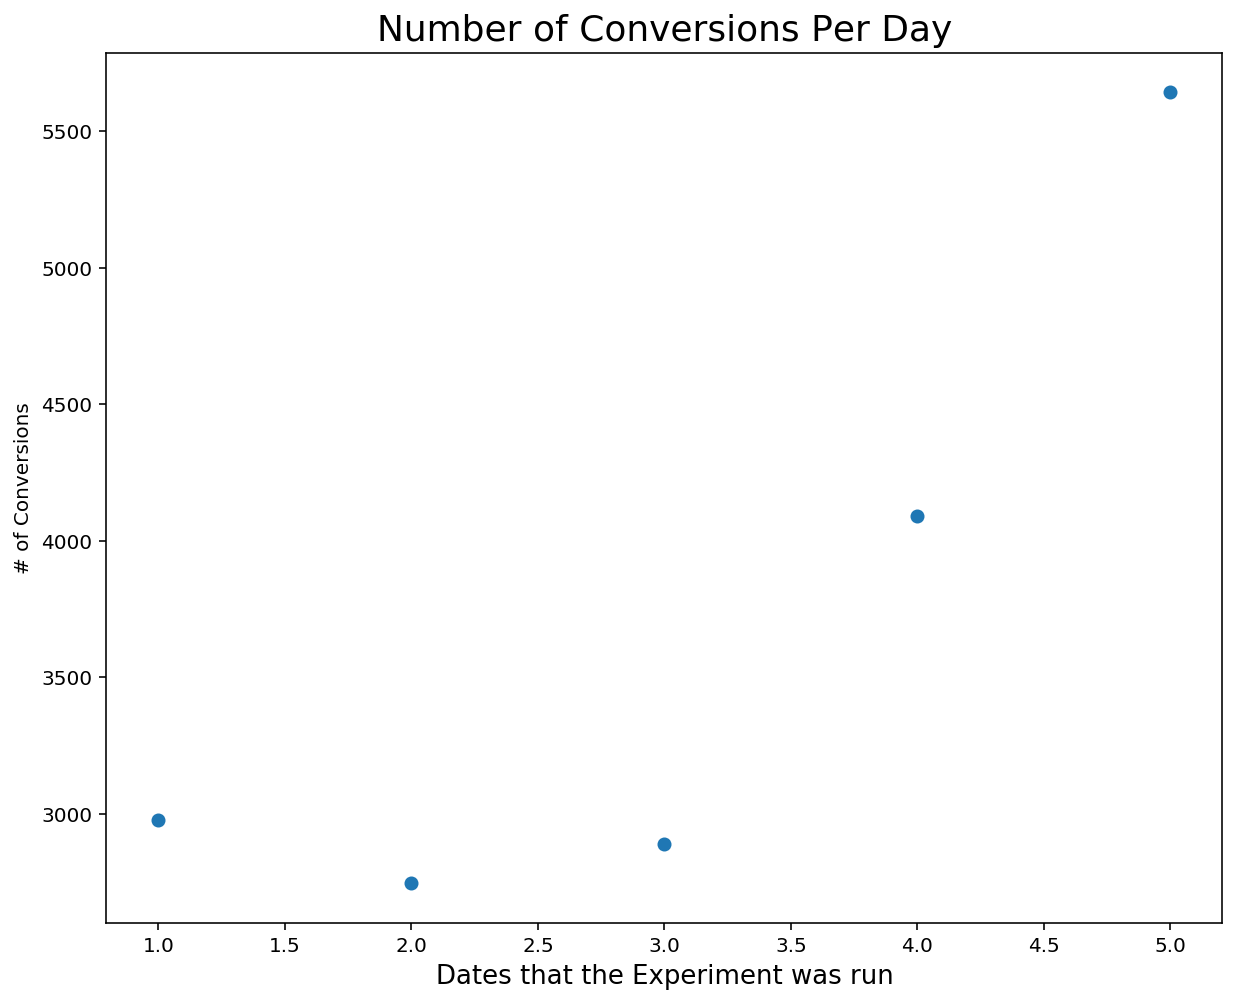

In [39]:
plot_scatter(x,y)

From this graph we see that the experiment was only run for 5 days. For succesful A/B tests, experiments should be kept running for at least a week. Usually experiments are run for 2 weeks to reveal weekly patterns. Another reason for running the test longer is so that they can receive more data from their customers.

### 2.) Test the amount of bias in the system
I will construct a decision tree to that classifies test or control based on the countries. In a fully randomized experiment, a split will be nearly impossible to find. The training data will contain all possible features of the tree, and the labels will be test or control assignment.

I have to first create dummy variables for all the Category values in the data. For this section I will use the countries not including Spain because those were the countries involved in the A/B Testing Experiments.

In [87]:
df_no_Spain.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,497851.0,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
1,290051.0,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
2,548435.0,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
3,540675.0,2015-12-03,Direct,Mobile,ES,None,Android_App,0,1,F,22.0,Venezuela
4,863394.0,2015-12-04,SEO,Mobile,Other,None,Android_App,0,0,M,35.0,Mexico


#### Create dummy variables

In [88]:
df = df_no_Spain.copy()
# Create dummy variables for Category values
df_is_country = pd.get_dummies(df['country'])
df_source = pd.get_dummies(df['source'])
df_device = pd.get_dummies(df['device'])
df_browser = pd.get_dummies(df['browser'])
df_sex = pd.get_dummies(df['sex'])
df_ads_channel = pd.get_dummies(df['ads_channel'])
df_browser_language = pd.get_dummies(df['browser_language'])
df_date = pd.get_dummies(df['date'])

# Add columns to dataframe
df[df_is_country.columns] = df_is_country
df[df_source.columns] = df_source
df[df_device.columns] = df_device
df[df_browser.columns] = df_browser
df[df_sex.columns] = df_sex
df[df_ads_channel.columns] = df_ads_channel
df[df_browser_language.columns] = df_browser_language
df[df_date.columns] = df_date

# Drop original columns
df = df.drop('country', axis=1)
df = df.drop('source', axis=1)
df = df.drop('device', axis=1)
df = df.drop('browser', axis=1)
df = df.drop('sex', axis=1)
df = df.drop('ads_channel', axis=1)
df = df.drop('browser_language', axis=1)
df = df.drop('date', axis=1) # resulted in NaNs for some reason

In [92]:
tree_label = pd.DataFrame(df['test'], columns=['test'])


Everything except test.

In [106]:
tree_features = df.copy().drop('test', axis=1, inplace=False)

I don't need the user_id, conversion or the age. Just testing whether countries are biased towards being selected as test or control.

In [110]:
tree_features = tree_features.drop(['user_id', 'conversion'], 
                                    axis=1,
                                   inplace=False)

In [112]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(tree_features, tree_label)
    print('Fitted model: {}'.format(fitted))
    predicted_labels = fitted.predict(tree_features)
    accuracy = accuracy_score(predicted_labels, tree_label)
    print('The accuracy for the decision tree classifier is {}'.format(accuracy*100))
    return fitted

def decision_tree():
    return run_model(DecisionTreeClassifier(max_leaf_nodes=3))

In [113]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=3, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The accuracy for the decision tree classifier is 54.012491117842856


In [114]:
feature_names = tree_features.columns
label_names = tree_label.columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
                           # check to see if I need to dummy variablize the labels before
                           # running Decision Tree
               class_names=['conrol', 'test'],
               filled=True, rounded=True,
               special_characters=True)
#graph = graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)

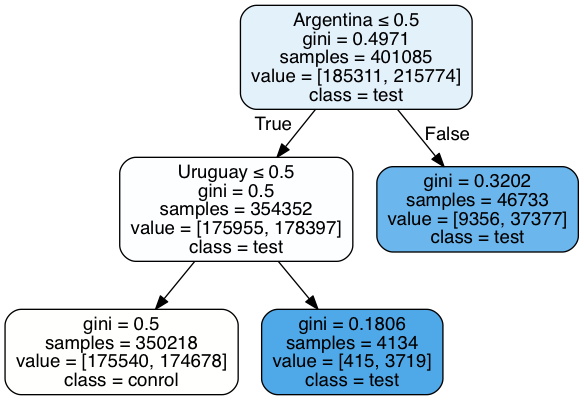

In [115]:
Image(graph.create_png())

If it were a perfectly random experiment there would be no splits on the country. Instead, there would be an equal probability of test and control, and the gini index should be 0.5. Instead, this is only the case in the leftmost leaf. This leaf contains countries that are not Uruguay or Argentina, and have an almost equal split between test and control. However, for Argentina, there is a 70% chance that the user is in the test group and for Uruguay there is an 80% chance the user is in test. I know there is a 70% chance given Argentina = 1 because the gini impurity index is at 0.3 for that leaf. Similarly, the gini impurity index is at 0.2 for Uruguay = 1, so there is a 80% chance the user is in test if she is from Uruguay.

Thus, the experiment was not randomized correctly and would need to rerun the experiments. In the new runs, it should control for country.

In [116]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [117]:
#control_countries = smf.ols(formula='conversion ~ country', data=df_notSpain).fit()

In [118]:
#control_countries.summary()

In [120]:
df_no_Spain.groupby('country').sum()[['conversion', 'test']].reset_index()

,country,conversion,test
0,Argentina,654,37377
1,Bolivia,541,5574
2,Chile,981,9884
3,Colombia,2775,26972
4,Costa Rica,284,2649
5,Ecuador,780,7859
6,El Salvador,415,4067
7,Guatemala,751,7503
8,Honduras,422,4207
9,Mexico,6468,64275


In [121]:
test_conversion = pd.DataFrame(df_test.groupby('country').mean()['conversion'])\
    .reset_index()
control_conversion = pd.DataFrame(df_control.groupby('country').mean()['conversion'])\
    .reset_index()

In [122]:
control_conversion.columns = ['country', 'control_conversion']
test_conversion.columns = ['country', 'test_conversion']

In [124]:
control_country = control_conversion.merge(test_conversion, on='country')

In [125]:
control_country

,country,control_conversion,test_conversion
0,Argentina,0.015071,0.013725
1,Bolivia,0.049369,0.047901
2,Chile,0.048107,0.051295
3,Colombia,0.052089,0.050571
4,Costa Rica,0.052256,0.054738
5,Ecuador,0.049154,0.048988
6,El Salvador,0.053554,0.047947
7,Guatemala,0.050643,0.048647
8,Honduras,0.050906,0.047540
9,Mexico,0.049495,0.051186


Note, this is what I did in the original SQL query. This is controlling for country and then checking how the test is doing for each country.

Need to calculate the p-value above.

In [127]:
control_country['diff_in_means'] = control_country['test_conversion'] - control_country['control_conversion']

In [130]:
df = control_country.copy()

In [162]:
def get_pval(countries):
    pvals = []
    for c in countries:
        _, pval = ttest_ind(df_test[df_test.country == c].conversion, 
                  df_control[df_control.country == c].conversion)
        pvals.append(pval)
    ser1 = pd.Series(pvals, name='pvals')
    ser2 = pd.Series(countries, name='country')
    
    return pd.concat([ser1, ser2], axis=1).sort_values('pvals',ascending=True)
    

In [163]:
pvals = get_pval(list(df.country))

In [164]:
pd.merge(pvals, control_country, on='country')

,pvals,country,control_conversion,test_conversion,diff_in_means
0,0.165547,Mexico,0.049495,0.051186,0.001692
1,0.248251,El Salvador,0.053554,0.047947,-0.005607
2,0.302871,Chile,0.048107,0.051295,0.003188
3,0.321766,Argentina,0.015071,0.013725,-0.001346
4,0.423733,Colombia,0.052089,0.050571,-0.001519
5,0.471721,Honduras,0.050906,0.047540,-0.003366
6,0.572165,Guatemala,0.050643,0.048647,-0.001996
7,0.573740,Venezuela,0.050344,0.048978,-0.001365
8,0.687863,Costa Rica,0.052256,0.054738,0.002482
9,0.705361,Panama,0.046796,0.049370,0.002575


Once we controlled for country, the test is clearly not significant. The country with the lowest pvalue is Mexico at 16.5%. 